# Plot processes

The WPS flyingpigeon provides several processes to perform plot subsetts of netCDF files.

They are several processes to perfom timeseries graphics as well as spatial visualisations as maps. 

In [1]:
# birdy client for communication with the server:
from birdy import WPSClient
from os import environ

# handling files and folders
from os import path, listdir
from urllib import request

# wait until WPS process is finished
import time

# to display external png graphics in notebook: 
from IPython.display import Image
from IPython.core.display import HTML 


In [2]:
# This cell is for server admnistration test purpose
# Ignore this cell and modify the following cell according to your needs

fp_server = environ.get('FYINGPIGEON_WPS_URL')
print(fp_server)  # link to the flyingpigoen server

http://localhost:8093/wps


In [3]:
# URL to a flyingpigeon server
# fp_server = 'https://pavics.ouranos.ca/twitcher/ows/proxy/flyginpigeon/wps'

In [4]:
fp_i = WPSClient(fp_server, progress=True)
fp = WPSClient(fp_server)

**read in the required files:**

this is an example of an local installation, where local files are processed
 
indices were calculated with the birdhouse WPS finch:
https://finch.readthedocs.io/en/latest/processes.html

In [5]:
# read in the existing indices based on bias_adjusted tas files:
tas_NER = '/home/nils/data/example_data/NER/'
tasInd_NER = [ tas_NER+f for f in listdir(tas_NER) if '.nc' in f ]

tasInd_NER.sort()


In [6]:
# frequencies
freq=['yr','mon']

# precipitation indices
# pr_indices = ['prcptot','rx1day','wetdays','cdd','cwd','sdii','rx5day']
tas_indice = 'tg_mean'

# titles = ['Somme annuelle des précipitations', 
#           'Jours de plus fortes précipitations',
#           'Nombre de jours humide',
#           'Journées consécutives de sécheresse', 
#           'Jours humides consécutifs', 
#           "Index d'intensité de précipitations", 
#           'Somme max. sur 5 jours consécutifs', 
#           'Températures moyennes annuelles']

dates = ['1976-01-01', '2005-12-31', '2036-01-01', '2065-12-31', '2071-01-01', '2099-12-30']

In [7]:
# find ensemble files for one indice based on pr files:

tasInd_NER = [ tas_NER+f for f in listdir(tas_NER) if '.nc' in f ]


resource = [f for f in tasInd_NER if tas_indice in f ] # and '_yr_' in f


#### Spaghetti Plot

A simple way of visualisation of an ensemble of datasets. The plot visualises historical and rcp runs in different colors 

In [8]:
out_plot = fp.plot_spaghetti(resource=resource, title='Test plot', 
                             delta = -273.15, # to convert K to C
                             figsize='9,5',# ymin=0, ymax=14  # 
                             )
len(out_plot.get())

1

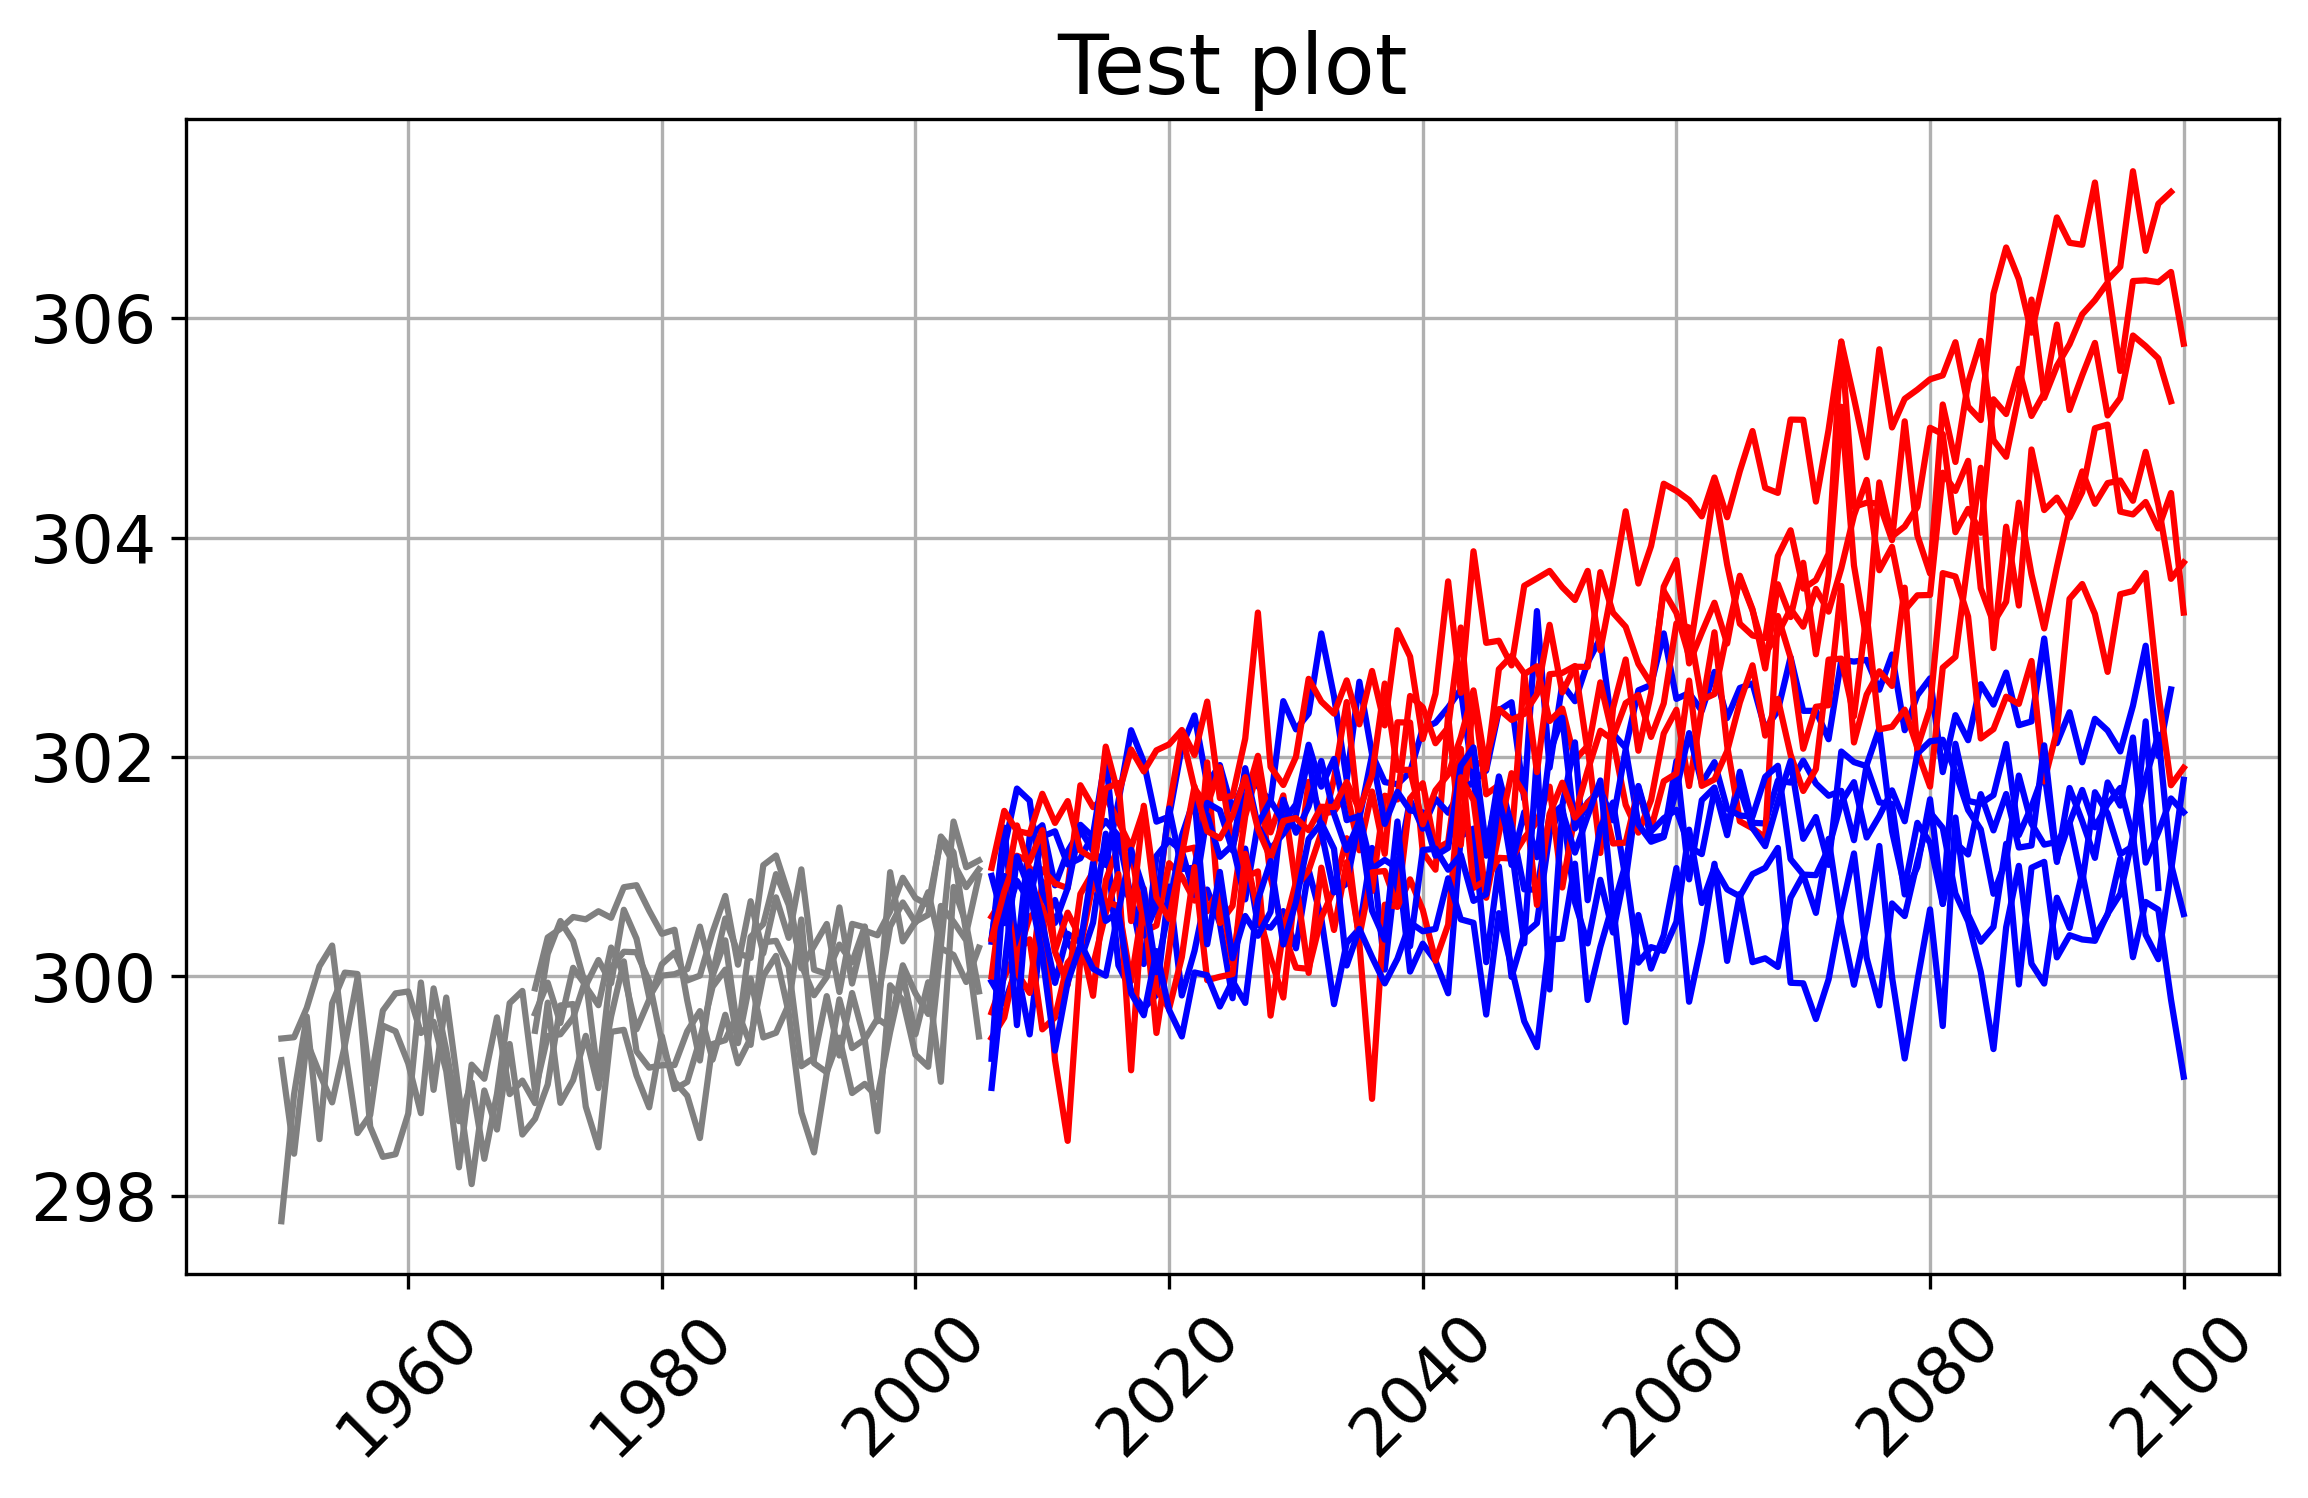

In [9]:
# display the output graphic url:
out_plot.get(asobj=True).plotout_spaghetti
# or with:
# Image(out.get()[0], width=400)

#### RCP uncertainty timeseries

An ensemble of indice files will be visualised as median and the appropriate uncertainties seperatled by historical and rcp runs. 

In [10]:
resp = fp.plot_uncertaintyrcp(resource=resource, title='Yearly mean temperature', delta = -273.15,
                            figsize='9,5', # ymin=20, ymax=100  # 
                           )

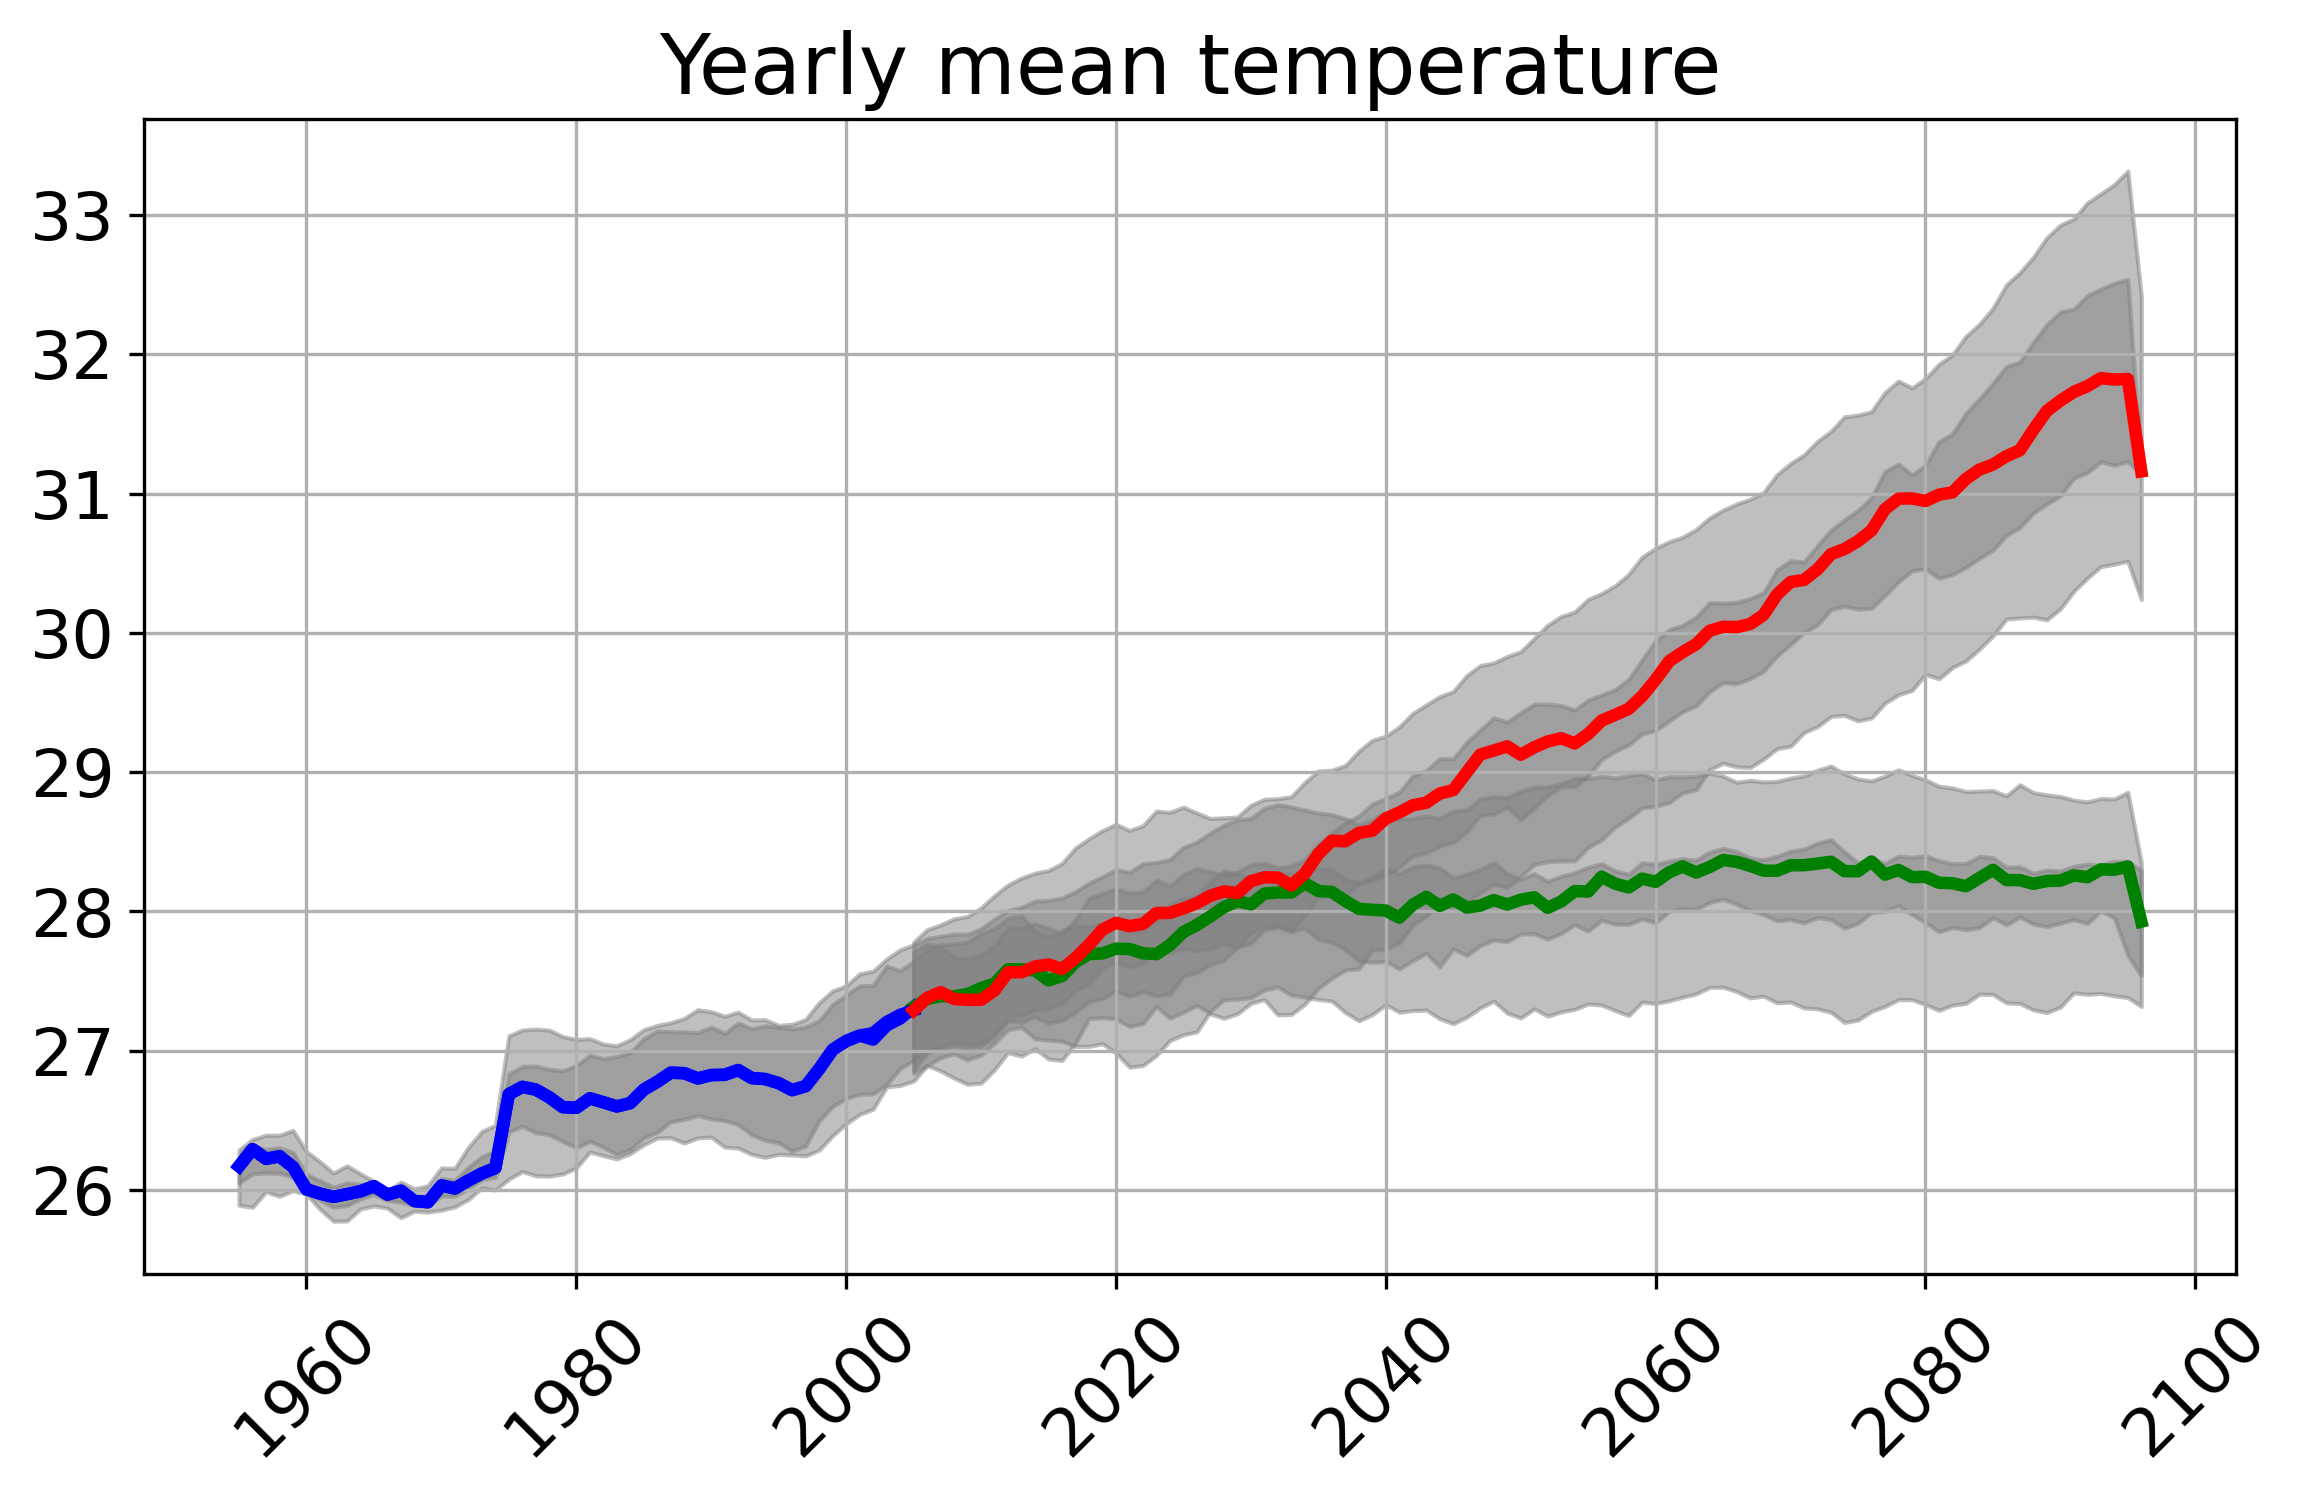

In [11]:
# onother way to display the output graphic.

# download the file 
out_file = '/tmp/ts_uncertainty_tg-yr.png'
request.urlretrieve(resp.get()[0], out_file)

# display the graphic:
Image(out_file, width=400)


#### Plot a map

Spatial visualisation of data as a mean over the time. 

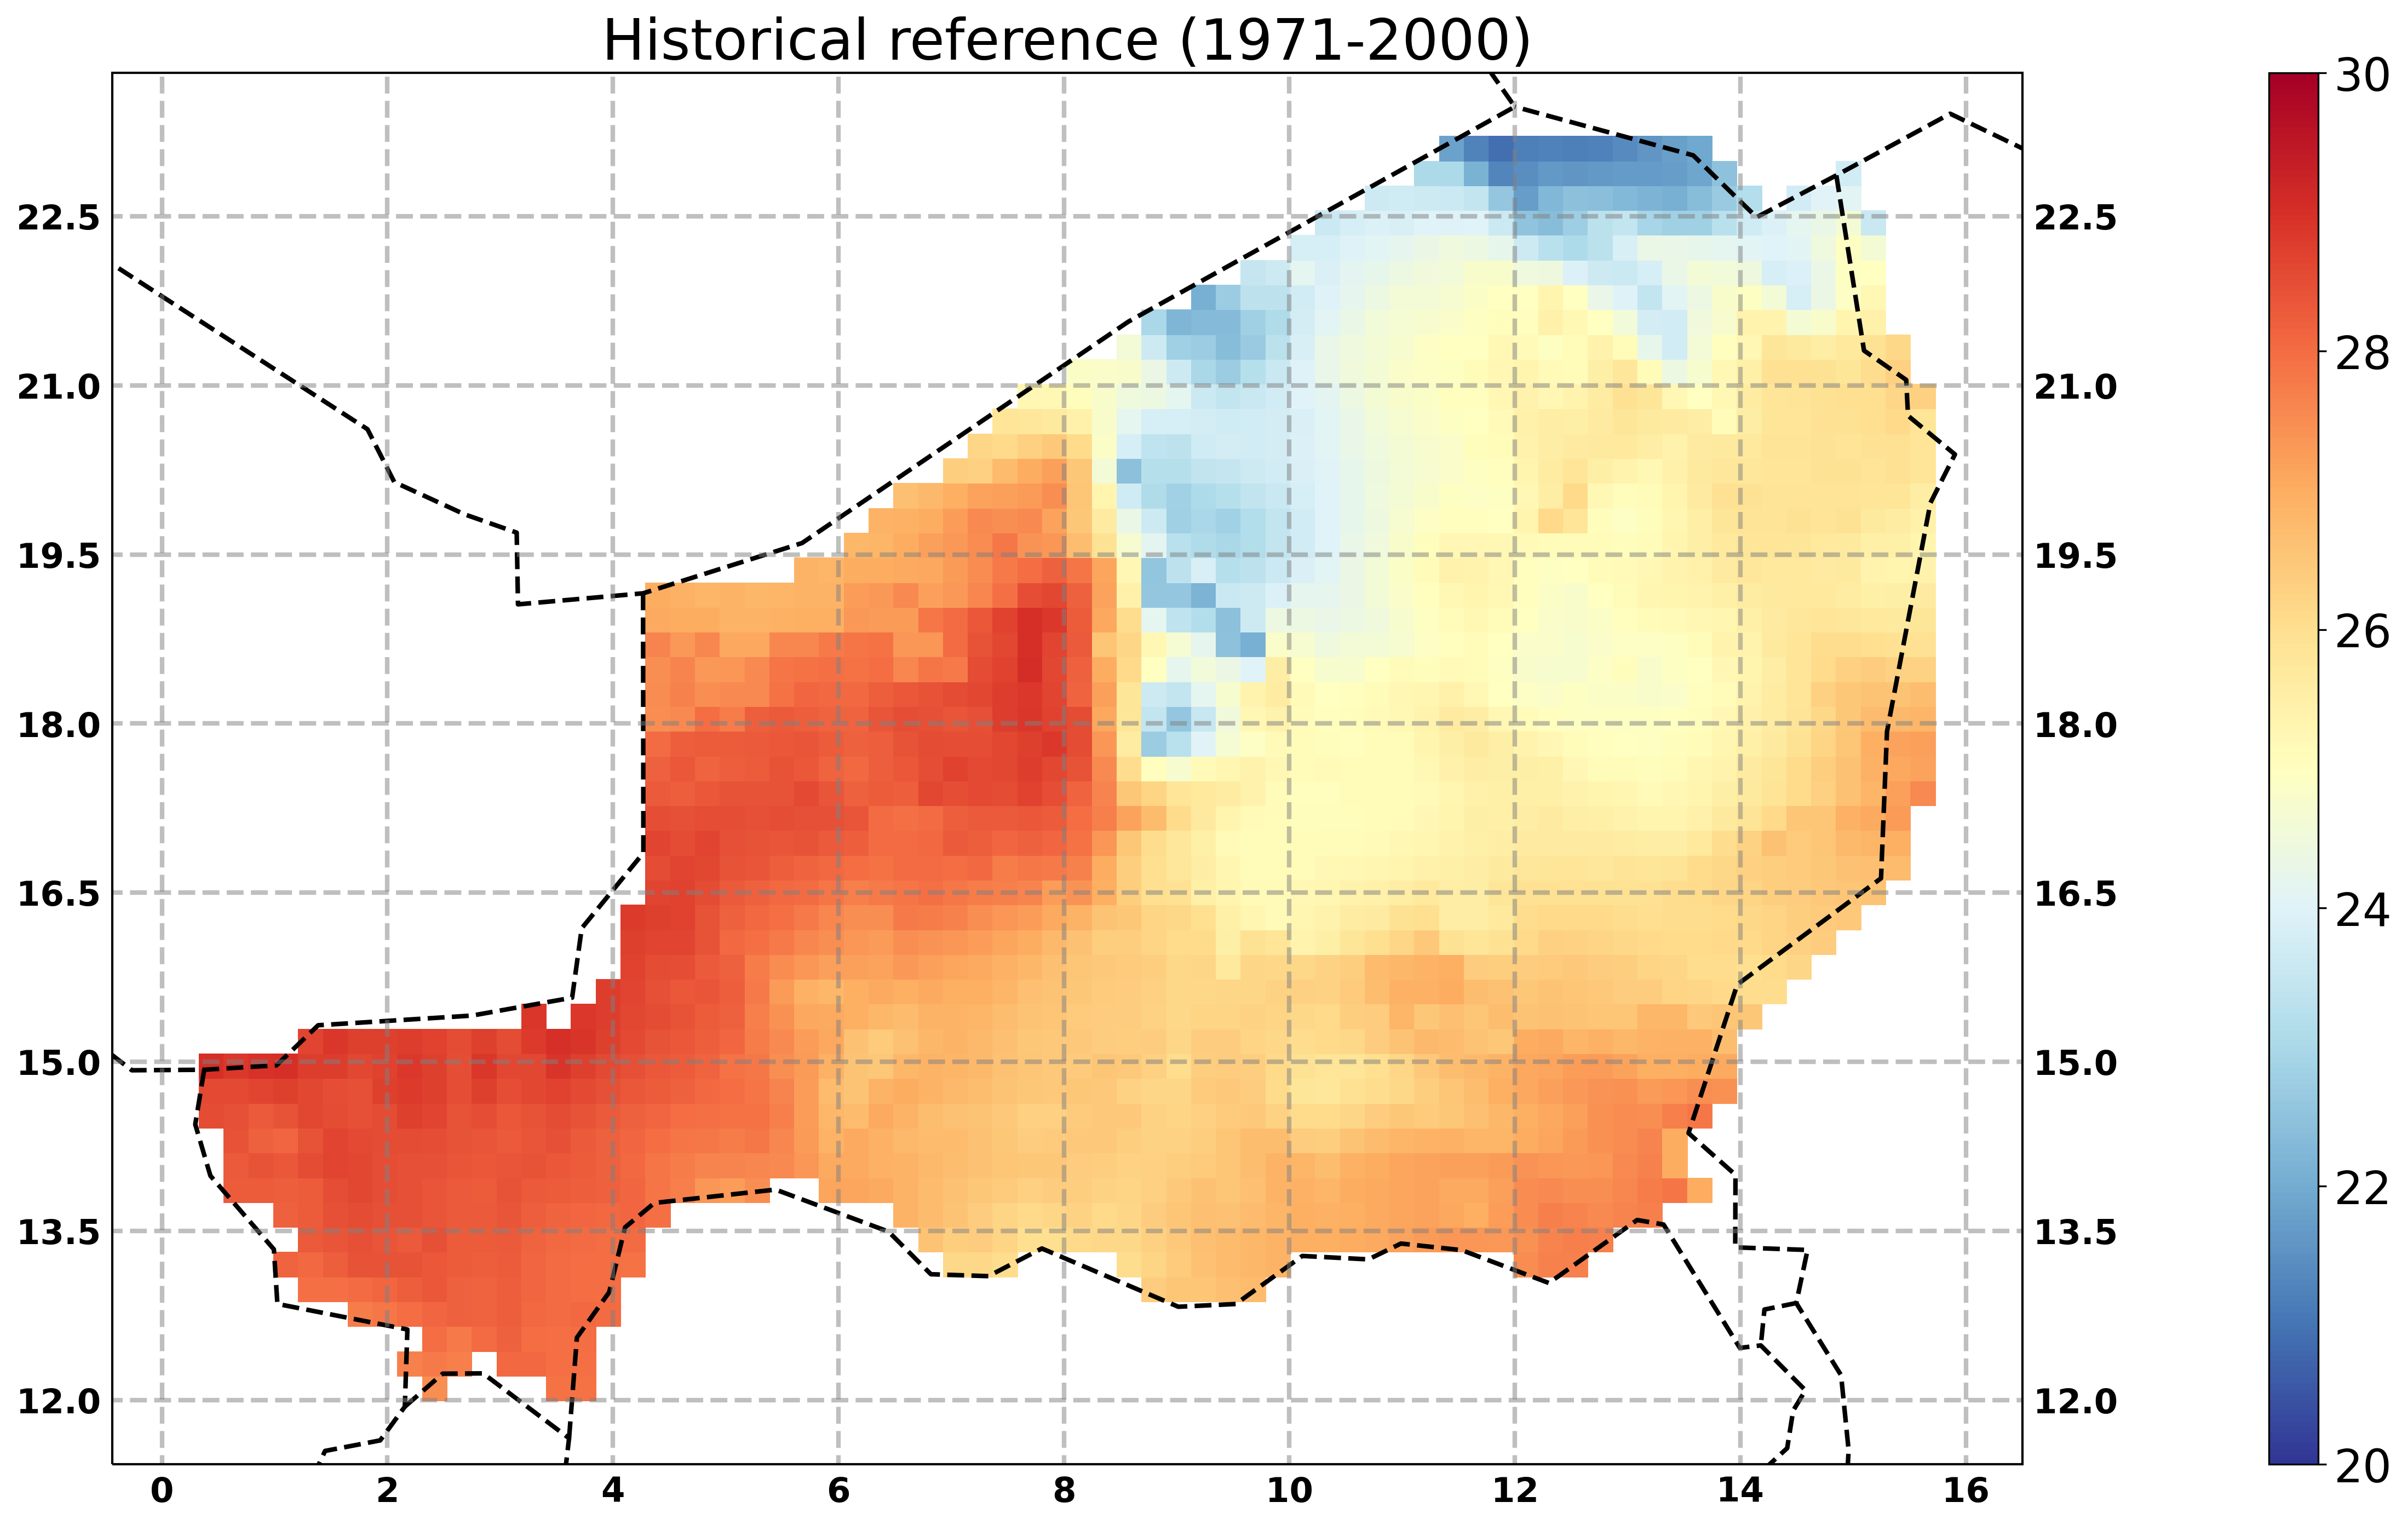

In [12]:
# select only the historical runs of the indices ensemble
hist = [f for f in resource if 'historical' in f]

# process the data of the years 1971-2000
out = fp.plot_map_timemean(resource=hist, title='Historical reference (1971-2000)',
                            delta = -273.15, 
                             datestart='1971-01-01', dateend='2000-12-31',  # subset a time range
                             vmin=20,  vmax=30, 
#                              cmap=''
                           ) # 

# display the output graphic
Image(out.get()[0], width=600)

#### plot a climate change signal

calculation of the differnence in a climate signal between a future projection to a reference periode 

In [13]:
dates = ['1971-01-01', '2000-12-31', '2036-01-01', '2065-12-31', '2071-01-01', '2100-12-31']

ref = [f for f in tasInd_NER if tas_indice in f  and 'historical' in f] # and fr in f
proj = [f for f in tasInd_NER if tas_indice in f and 'rcp85' in f]

ref.sort()
proj.sort()

In [14]:
resp = fp_i.climatechange_signal(resource_ref=ref,
                                resource_proj=proj,
#                                 variable='tg-mean',
                                title='Scenario {} {} ({})'.format('RCP 8.5', tas_indice, '2071-2100'),
                                datestart_ref=dates[0],
                                dateend_ref=dates[1],
                                datestart_proj=dates[2],
                                dateend_proj=dates[3],
#                                 vmin=0 , vmax=7,
#                                 cmap='BrBG'
                               )

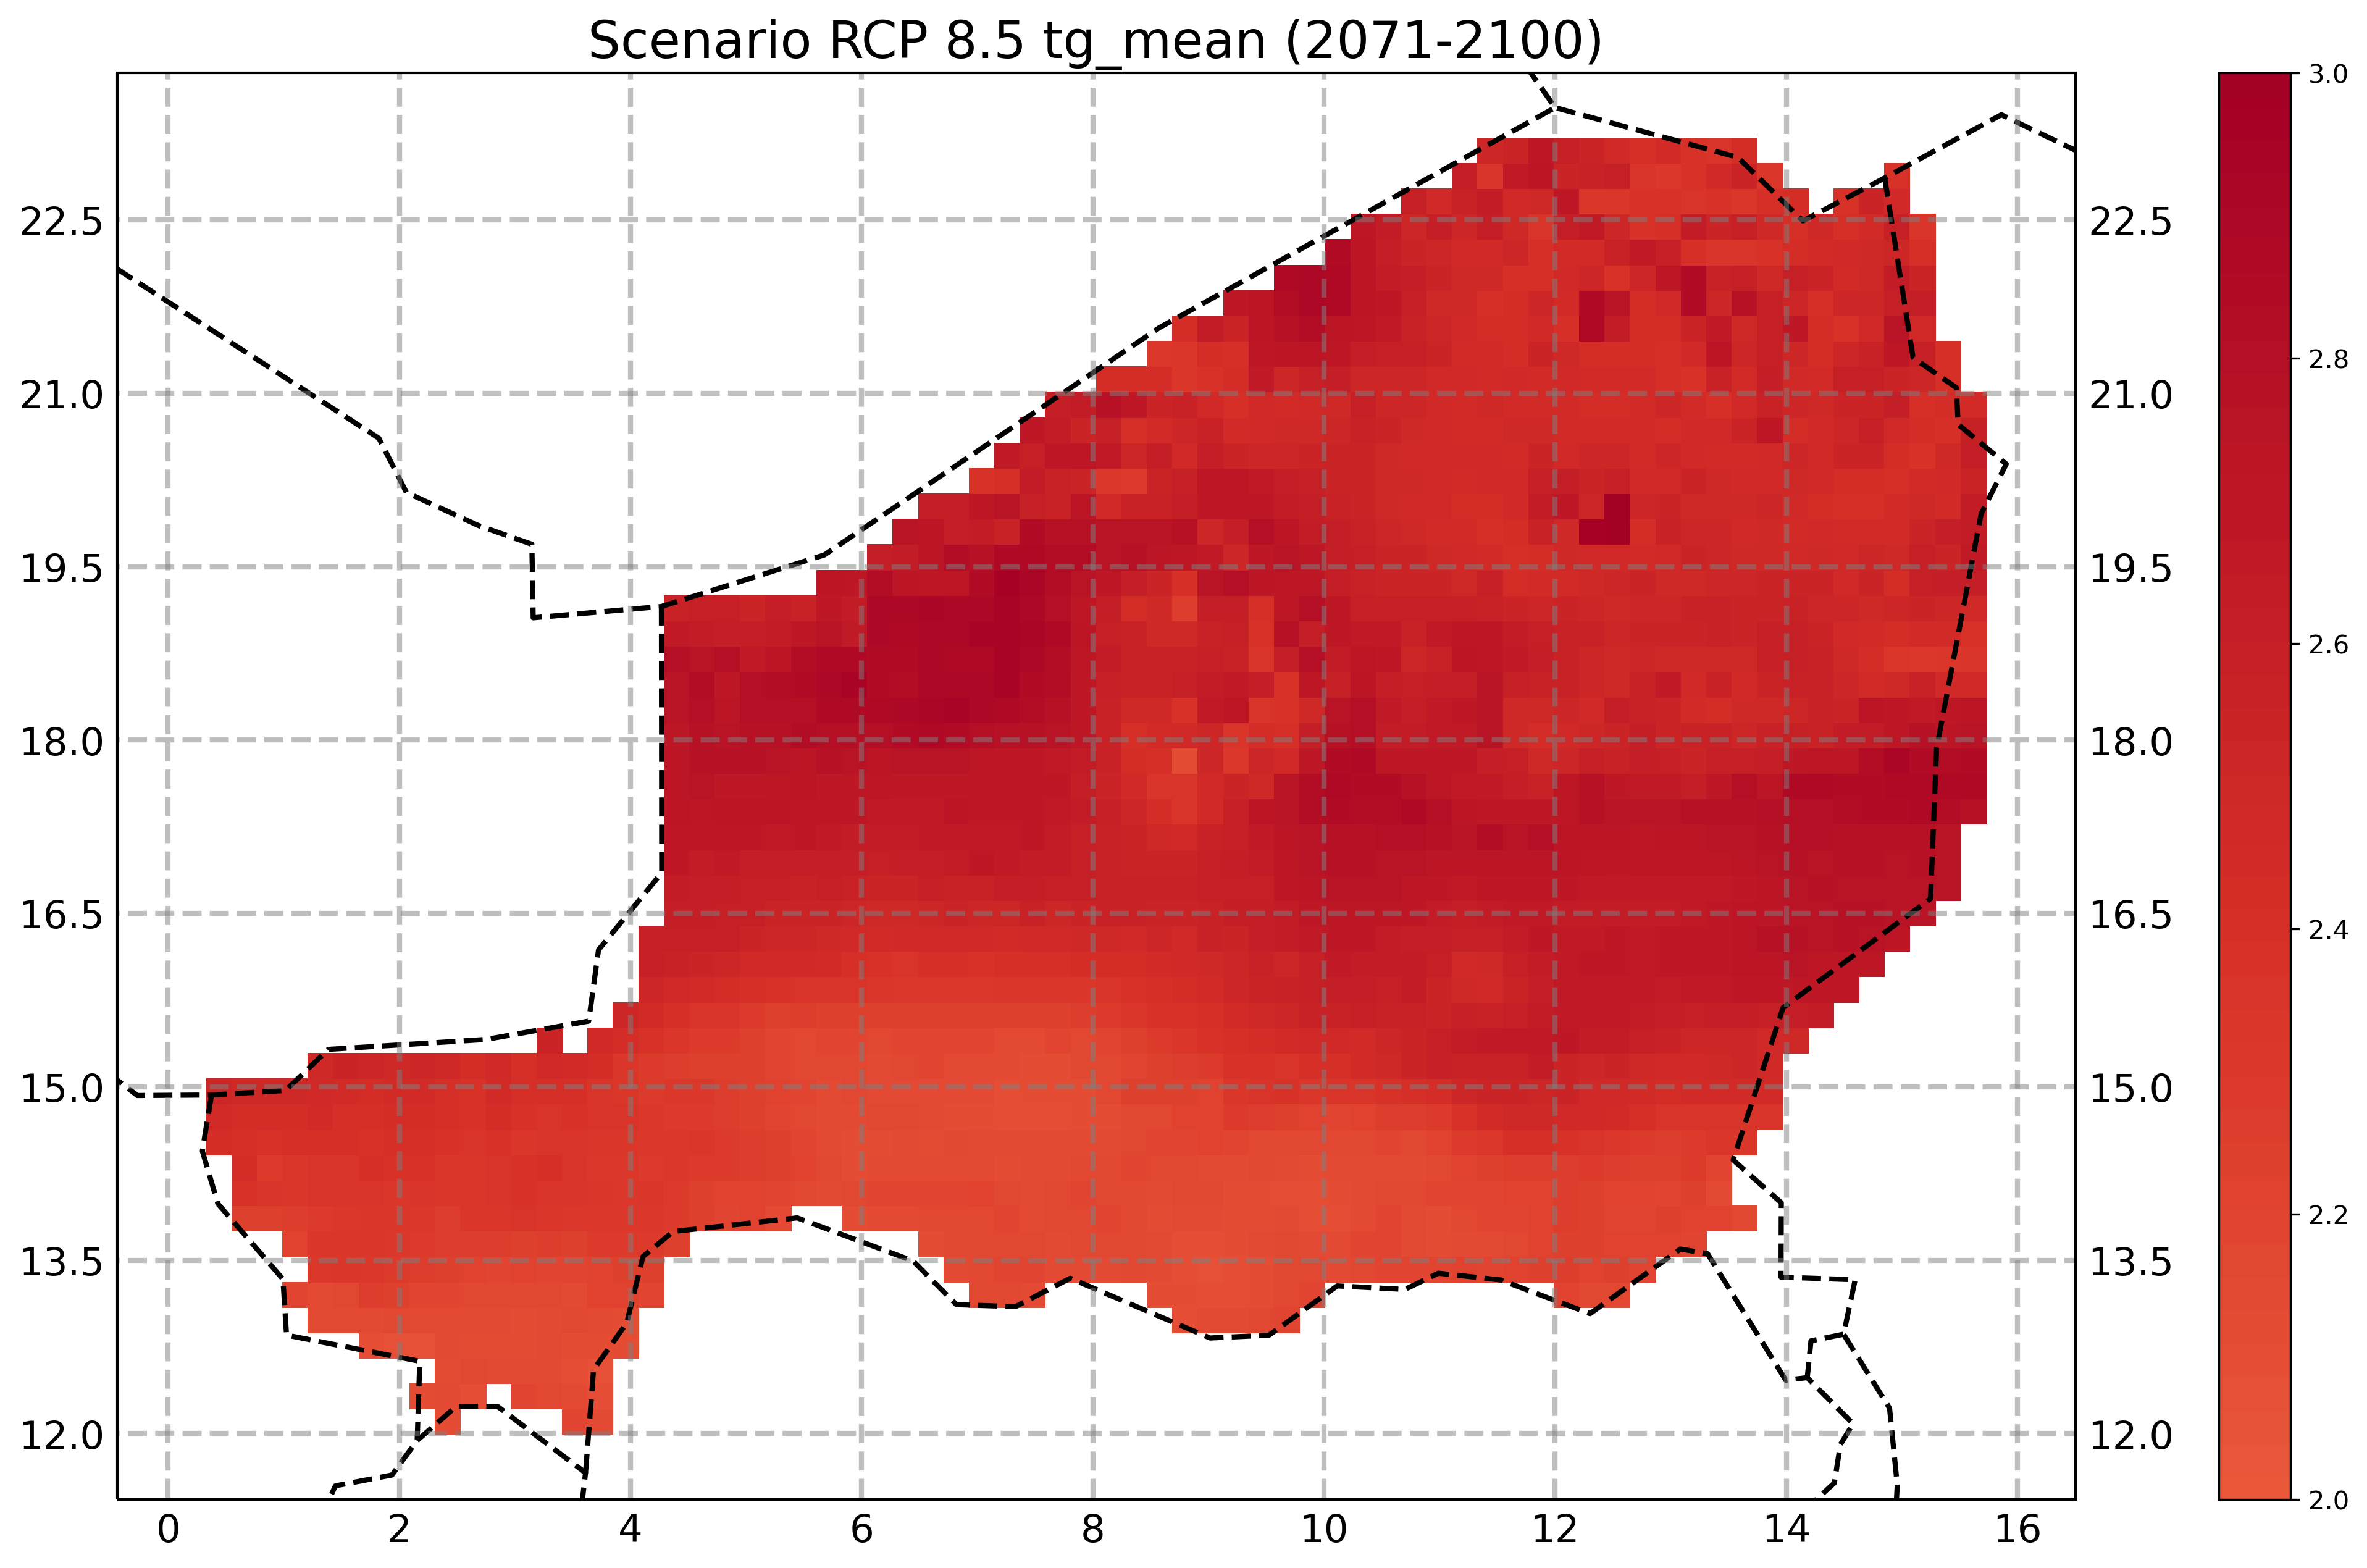

In [15]:
# using fp_i you need to wait until the processing is complete!

timeout = time.time() + 60*1   # 1 minute from now

while resp.getStatus() != 'ProcessSucceeded': 
    time.sleep(1)
    if time.time() > timeout:  # to avoid endless waiting if the process failed
        break

Image(resp.get()[2], width=600)